# Whisper Transcribe
OpenAI Whisper test and evaluation

## Execution

For the different available models, perform transcription and match the output to the manual transcript.

In [50]:
import numpy as np
import whisper
from datetime import datetime
from difflib import SequenceMatcher
from matplotlib import pyplot as plt

In [87]:
# load model
model = whisper.load_model("small")  # select model: tiny, base, small, medium, large

In [73]:
audio_file = "/Users/jannikschmied/Downloads/20221007_stochastik_zufall.m4a"  # path to file
audio_length = 22  # seconds
manual_transcript = """Zufall ist, in unserem Kontext, nicht ein im Hintergrund unseres Daseins wirkendes Prinzip, das unser Leben zu beeinträchtigen in der Lage ist, sondern das Wort dient zur Charakterisierung einer Situation, in der wir auf Grund fehlender Informationen den Ausgang eines Experiments nicht vorhersehen können."""

In [86]:
similar = lambda a, b: SequenceMatcher(None, a, b).ratio()

In [88]:
timestamp_start = datetime.now()
result = model.transcribe(audio_file, language="German")
timestamp_end = datetime.now()

duration = (timestamp_end - timestamp_start).seconds
factor = round(duration/audio_length, 2)
match = round(similar(manual_transcript, result['text']) * 100, 2)

print(f"[+] Task executed in {duration}s (factor 1:{factor}), matching: {match}%")
print("[i] Result:\n", result["text"])

/usr/local/anaconda3/envs/data-analysis/lib/python3.10/site-packages/whisper/transcribe.py:78: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


[+] Task executed in 36s (factor 1:1.64), matching: 98.52%
[i] Result:
  Zufall ist in unserem Kontext nicht ein im Hintergrund unseres Dasein wirkendes Prinzip, das unser Leben zu beeinträchtigen in der Lage ist, sondern das Wort dient zur Charakterisierung einer Situation, in der wir aufgrund fehlender Information den Ausgang eines Experiments nicht vorhersehen können.


## Evaluation

Evaluation and visualization of the outcome.

In [82]:
transcription_times_by_model = np.array([6, 11, 40, 155, 333])  # in seconds
correctness_rate_by_model = np.array([80.46, 96.2, 98.52, 99.18, 98.85])  # in percent
transcription_time_avg = np.mean(transcription_times_by_model)
legend = ["tiny", "base", "small", "medium", "large"]

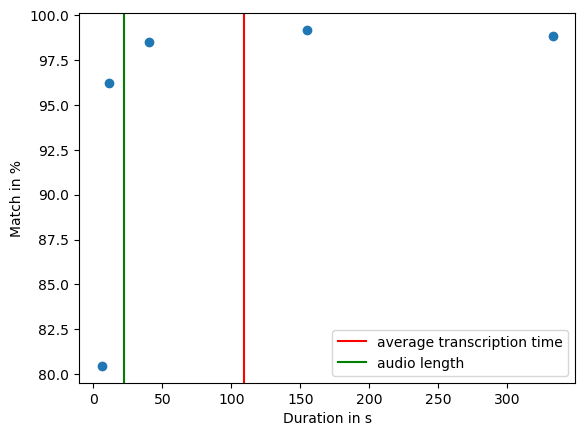

In [85]:
# plt.bar(legend, transcription_times_by_model)
plt.scatter(transcription_times_by_model, correctness_rate_by_model)
plt.axvline(transcription_time_avg, color="red", label="average transcription time")
plt.axvline(audio_length, color="green", label="audio length")
plt.legend(loc="lower right")
plt.xlabel("Duration in s")
plt.ylabel("Match in %")
plt.show()

# Result

Research has shown, that the small model offers the best time-match tradeoff with a time factor of only 1:1.64 and a accuracy of 98.5%. Interestingly, the large model performed worse than the medium one, although needing nearly twice as much time.